<a href="https://colab.research.google.com/github/JungOhLee/LiTS_example/blob/main/CropAllLiver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!pip install monai
!pip install nibabel
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 35.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 26.5 MB/s eta 0:00:00


In [ ]:
import os
import SimpleITK as sitk
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd

import nibabel
from monai.transforms import Resize

import time

In [ ]:
from monai.transforms import CropForeground
import nibabel as nib

In [ ]:
import matplotlib.pyplot as plt
from skimage import color

def slice_img(img, offset, end, interval):
  if end is None:
    end = len(img)
  else: 
    if end > len(img): 
      end = len(img)
    if end <= offset:
      end = offset + 1
  return img[offset:end:interval]

def show_numpy_img(np_img, offset=0, end=None, interval=5, title=''): 
  sliced_img = slice_img(np_img, offset, end, interval)

  figsize_per_img = 3
  num_col = 5
  num_row = int(np.ceil(sliced_img.shape[0] / num_col))
  # fig, axs = plt.subplots(num_row, num_col, figsize = (figsize_per_img*num_col, figsize_per_img*num_row))
  plt.figure(figsize=(figsize_per_img*num_col, figsize_per_img*num_row))
  for i, img in enumerate(sliced_img):
    if i >= num_col*num_row:
      continue
    # axs[i].imshow(img)
    plt.subplot(num_row, num_col, i+1)
    plt.imshow(img, 'gray')
    # plt.title()
  plt.suptitle(title)
  plt.tight_layout()
  plt.show()

#npy image 정보 보여주기 
def show_img_info(np_img):
  print('Shape:', np_img.shape)
  print('DType:', np_img.dtype)
  print('Max:', np_img.max())
  print('Min:', np_img.min())
  print(np_img)


#npy image, npy label 
#image, label 동시에 그려줌
def plot_img_and_label(np_img, label, interval = 5, offset = 0, end=None, figsize_per_image = 5):
  sliced_img = slice_img(np_img, offset, end, interval)
  sliced_label = slice_img(label, offset, end, interval)
  
  num_row = len(sliced_img)
  num_col = 2

  f = plt.figure(figsize=(figsize_per_image*num_col, figsize_per_image*num_row))

  for i in range(0, num_row):
    plt.subplot(num_row, num_col, i*num_col+1)
    tissue_image = sliced_img[i]
    plt.imshow(tissue_image, 'gray')

    plt.subplot(num_row, num_col, i*num_col+2)
    mask = sliced_label[i]
    # # Method with SimpleITK
    # label_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(0,255,0))
    # plt.imshow(sitk.GetArrayFromImage(label_on_tissue), 'gray')
    # Method with skimage
    label_on_tissue = color.label2rgb(mask,tissue_image, bg_label=0)
    plt.imshow(label_on_tissue)

  plt.tight_layout()
#   plt.show()
  return f

In [ ]:
def plot_img_label_pred(image_npy, label_npy, pred_npy, interval = 5, offset = 0, end=None, figsize_per_image = 5, show_only_positive = False):
    sliced_img = slice_img(image_npy, offset, end, interval)
    sliced_label = slice_img(label_npy, offset, end, interval)
    sliced_pred = slice_img(pred_npy, offset, end, interval)

    if show_only_positive:
        positive_idx = (sliced_label + sliced_pred).sum(axis = (1,2)) > 0.5
        sliced_img = sliced_img[positive_idx]
        sliced_label = sliced_label[positive_idx]
        sliced_pred = sliced_pred[positive_idx]
    
    num_row = len(sliced_img)
    num_col = 3
    
    plt.figure(figsize=(figsize_per_image*num_col, figsize_per_image*num_row))

    for i in range(0, num_row):
        plt.subplot(num_row, num_col, i*num_col+1)
        tissue_image = sliced_img[i]
        plt.imshow(tissue_image, 'gray')

        plt.subplot(num_row, num_col, i*num_col+2)
        mask = sliced_label[i]
        label_on_tissue = color.label2rgb(mask,tissue_image, bg_label=0)
        # label_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(0,255,0))
        plt.imshow(label_on_tissue)
        
        plt.subplot(num_row, num_col, i*num_col+3)
        mask = sliced_pred[i]
        pred_on_tissue = color.label2rgb(mask,tissue_image, bg_label=0)
        # pred_on_tissue = sitk.LabelMapContourOverlay(sitk.Cast(sitk.GetImageFromArray(mask), sitk.sitkLabelUInt8), sitk.GetImageFromArray(tissue_image), opacity=0.7, contourThickness=[2,2], colormap=(255,0,0))
        plt.imshow(pred_on_tissue)

    plt.tight_layout()
    plt.show()

In [ ]:
pred_dir = '/gdrive/MyDrive/LiTS_sample/preds'
image_dir = '/gdrive/MyDrive/LiTS_sample/image'
label_dir = '/gdrive/MyDrive/LiTS_sample/mask'

image_crop_dir = '/gdrive/MyDrive/LiTS_sample/image_crop'
label_crop_dir = '/gdrive/MyDrive/LiTS_sample/mask_crop'

In [ ]:
def get_image_by_idx(i):
  nifti_file = nib.load(os.path.join(image_dir, f'volume-{i}.nii'))
  img = nifti_file.get_fdata()
  return img

def get_pred_by_idx(i):
  return np.load(os.path.join(pred_dir, f'volume-{i}.npy'))
  
def get_label_by_idx(i):
  nifti_file = nib.load(os.path.join(label_dir, f'segmentation-{i}.nii'))
  img = nifti_file.get_fdata()
  return img


In [ ]:
def adjust_window(image, window):
    width = window[0]
    level = window[1]
    upper = level+width/2
    lower = level-width/2
    copied_image = image.clip(lower, upper)
    copied_image = copied_image-lower
    return (copied_image/(upper-lower))

In [ ]:
# i = 2
# image = get_image_by_idx(i).transpose([2,1,0])
# label = get_label_by_idx(i).transpose([2,1,0])
# pred = get_pred_by_idx(i).transpose([2,1,0])
# pred = np.flip(pred,(1,2))

In [ ]:
# cropper = CropForeground(margin = [2,10,10], channel_indices = 2)
# stacked = np.stack([label, image, pred])
# cropped = cropper(stacked)

In [ ]:
# plot_img_label_pred((adjust_window(image,(700,200))*255).astype(np.uint8), label.astype(np.uint8), pred.astype(np.uint8), show_only_positive = True, interval =5)

In [ ]:
os.makedirs(image_crop_dir, exist_ok=True)
os.makedirs(label_crop_dir, exist_ok=True)

crop_log_df = pd.DataFrame(columns=['Case','Min','Max'])

for i in range(51):
  cropper = CropForeground(margin = [2,10,10], channel_indices = 2, return_coords=True)
  image = get_image_by_idx(i).transpose([2,1,0])
  label = get_label_by_idx(i).transpose([2,1,0])
  pred = get_pred_by_idx(i).transpose([2,1,0])
  pred = np.flip(pred,(1,2))

  stacked = np.stack([label, image, pred])
  cropped, min_point, max_point = cropper(stacked)
  label_crop = cropped[0]
  image_crop = cropped[1]
  pred_crop = cropped[2]
    # plot_img_label_pred((adjust_window(image_crop,(700,200))*255).astype(np.uint8), label_crop.astype(np.uint8), pred_crop.astype(np.uint8), show_only_positive = True, interval =4)

  image_crop_path = os.path.join(image_crop_dir, f'volume-{i}')
  label_crop_path = os.path.join(label_crop_dir, f'volume-{i}')
  np.save(image_crop_path, image_crop.astype(np.int16))
  np.save(label_crop_path, label_crop.astype(np.uint8))
  crop_log_df.loc[i] = [f'volume-{i}', min_point, max_point]
crop_log_df.to_csv(os.path.join(image_crop_dir, 'crop_info.csv'))

In [ ]:
for row_i, row in crop_log_df.iterrows():
  max_points = row['Max']
  min_points = row['Min']
  res =[]
  for i in range(len(max_points)):
    res.append(max_points[i] - min_points[i])
  print(res)

[32, 252, 332]
[31, 264, 344]
[152, 284, 328]
[178, 316, 280]
[266, 248, 320]
[183, 240, 228]
[193, 252, 244]
[180, 292, 276]
[189, 260, 248]
[183, 248, 256]
[191, 280, 272]
[198, 308, 316]
[193, 300, 344]
[145, 260, 232]
[255, 304, 486]
[184, 320, 276]
[197, 268, 316]
[209, 268, 260]
[201, 220, 200]
[196, 296, 292]
[210, 268, 292]
[182, 276, 300]
[49, 188, 172]
[122, 272, 244]
[128, 312, 344]
[238, 204, 308]
[207, 212, 268]
[387, 220, 280]
[102, 300, 364]
[118, 236, 260]
[126, 276, 248]
[71, 280, 272]
[120, 288, 304]
[100, 296, 272]
[111, 264, 296]
[120, 276, 408]
[88, 248, 260]
[100, 256, 284]
[101, 256, 288]
[192, 240, 324]
[93, 308, 348]
[101, 228, 336]
[106, 224, 268]
[118, 328, 428]
[111, 312, 300]
[61, 284, 308]
[43, 236, 300]
[91, 260, 296]
[87, 252, 336]
[78, 204, 208]
[71, 192, 252]


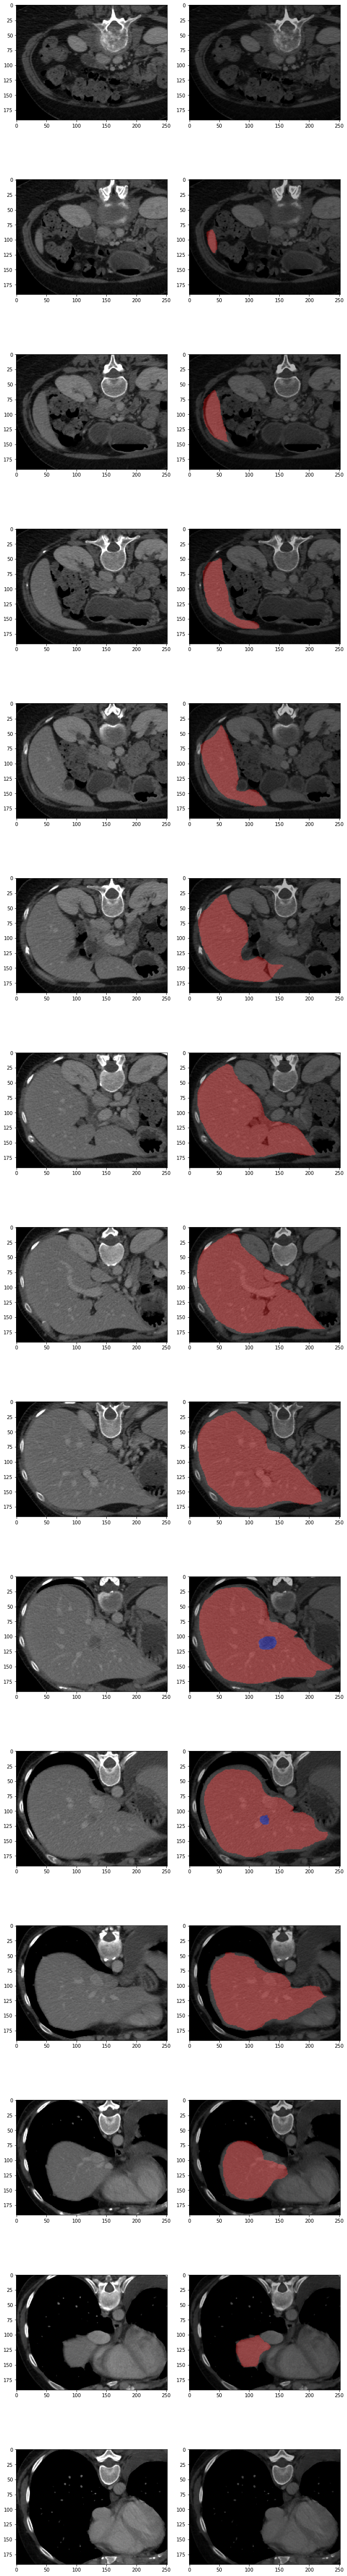

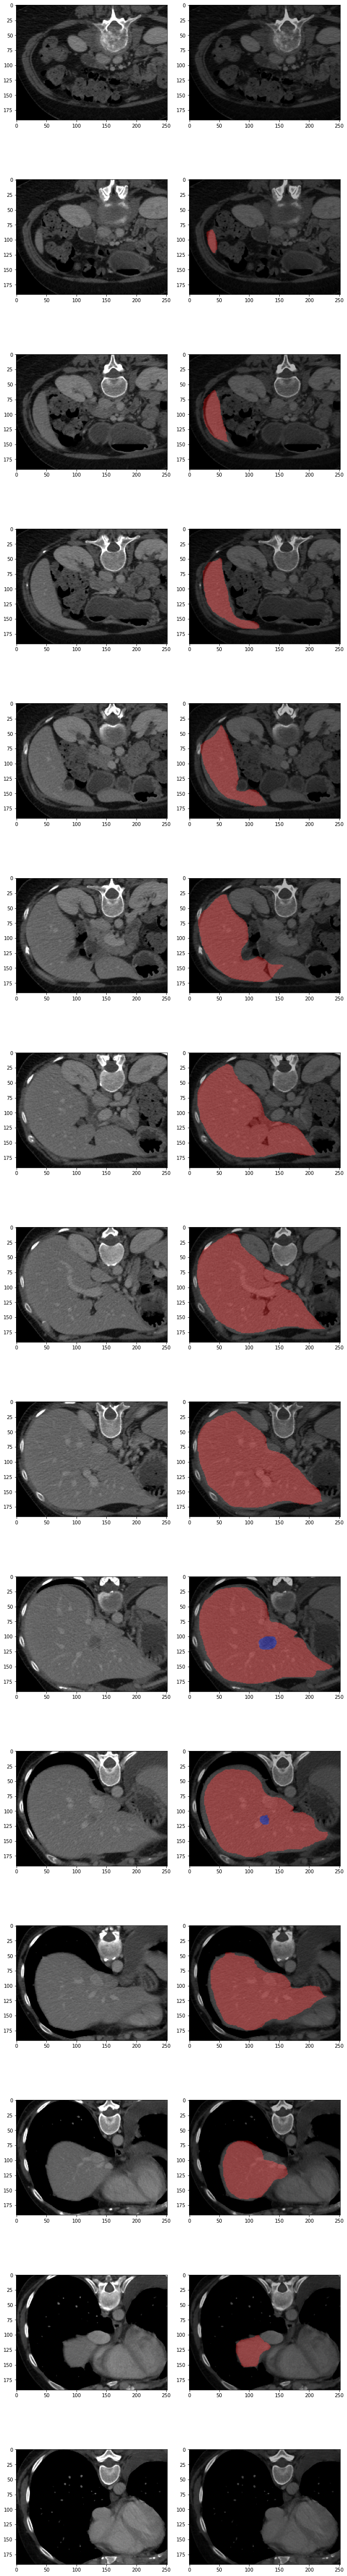

In [53]:
sample_image = np.load(os.path.join(image_crop_dir, 'volume-50.npy'))
sample_label = np.load(os.path.join(label_crop_dir, 'volume-50.npy'))
plot_img_and_label((adjust_window(sample_image,(700,200))*255).astype(np.uint8), sample_label)